# Dimensionality reduction using graphs

In [ ]:
!pip install umap-learn
!pip install node2vec
!pip install pyDRMetrics
import sys
if sys.version_info[:2] == (3,6):
  !pip install stellargraph
else:
  print('To install stellargraph, python 3.6 is needed. Without it, GraphSAGE will not work. Other algortihms work.')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
To install stellargraph, python 3.6 is needed. Without it, GraphSAGE will not work. Other algortihms work.


Please, upload **source.zip** here

In [ ]:
from google.colab import files
f = files.upload()

Saving source.zip to source.zip


In [ ]:
!unzip source.zip

In [ ]:
from utils import visualization, weights, features, build, embedding, dim_reduction, evaluation, utils
from data import preprocessing, small
import numpy as np
import sys
from sklearn.datasets import load_iris, load_digits
from sklearn.decomposition import PCA
import umap

## Graph building

At first, we illustrate our graph building algorithm on toy dataset.

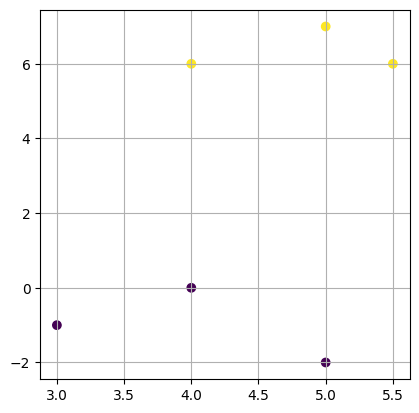

In [ ]:
data = np.array([[3,-1],
                 [4,0],
                 [5,-2],
                 [4,6],
                 [5,7],
                 [5.5,6]])
labels=[0,0,0,1,1,1]
visualization.show_data(data=data, labels=labels, square=True)

We create an instance of CheapestBuilder class. This is our main algorithm for graph building. We also created other graph building algorithms shown at the end of the notebook.

The Cheapest builder computes pairwise distances between datapoints, sorts them from the shortest to longest and then adds edges from the shortest one by one until a connected graph is obtained.

Weights can be assigned as a function of distances. Here we use w=1/distance (weights.reciprocal). We also implemented w=1/(distance)^k (weights.reciprocal_pow)

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [ ]:
builder.build(data)
graph = builder.graph

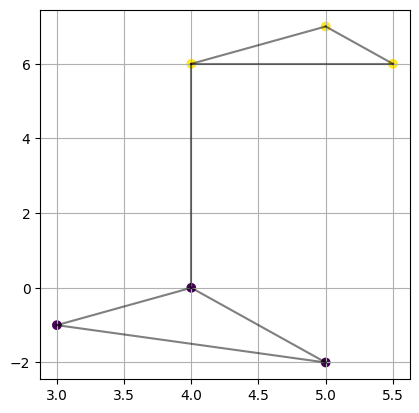

In [ ]:
visualization.show_data(data=data, graph=graph, labels=labels, square=True)

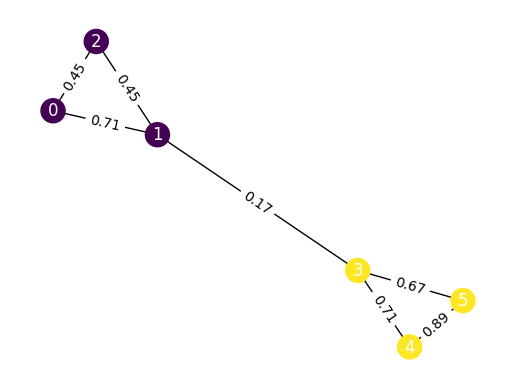

In [ ]:
visualization.show_graph(graph=graph, labels=labels, dpi=600, show_numbers=True)

## Node embedding

Having a graph representing our data, we can use it to generate low-dimensional embeddings. At first, we use the graph without any node features, then we add features for using GraphSAGE.

### Without node features
Having no node features, we use only the graph itself and edge weights. For embedding, we can use the force-directed Spring and Kamada & Kawai algorithms provided by networkX library

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)
builder.build(data)

#### Spring

We implemented various embedding methods as classes in embedding module.

In [ ]:
embedder = embedding.SpringEmbedder()
embedder.embed(builder.graph)

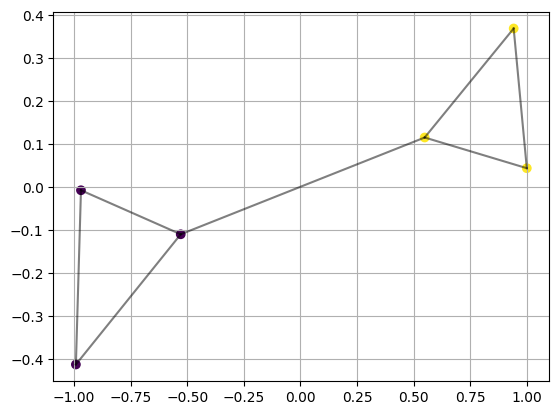

In [ ]:
visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

#### Kamada Kawai

In [ ]:
embedder = embedding.KamadaKawaiEmbedder()
embedder.embed(builder.graph)

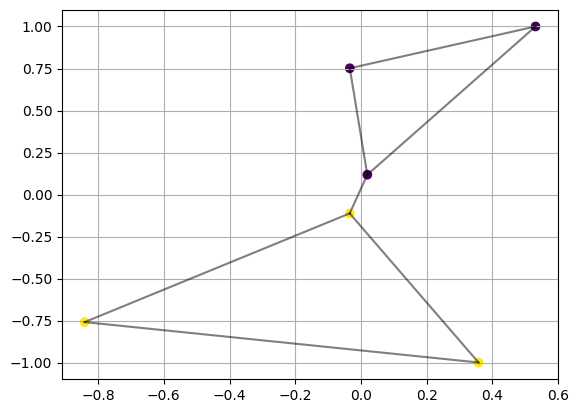

In [ ]:
visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

### With node features
We can add all the features from initial dataset as node features. Then we use GraphSAGE to learn embeddings.

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal, feature_fun=features.feature_coords)
builder.build(data)

#### GraphSAGE

In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    embedder = embedding.GraphSAGEEmbedder()
    embedder.embed(builder.graph)

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    visualization.show_data(embedder.embeddings, graph=graph, labels=labels)

Unsupported python version, use python 3.6


## Results on real datasets
### Dataset: Iris

For real datasets, we first remove duplicities, as we want to avoid nodes with distance 0.

In [ ]:
iris = load_iris()
data = iris.data
labels = iris.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Spring

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

The whole dimensionality reduction pipeline is implemented as a reduce_dimension function in dim_reduction module

In [ ]:
embedder = embedding.SpringEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

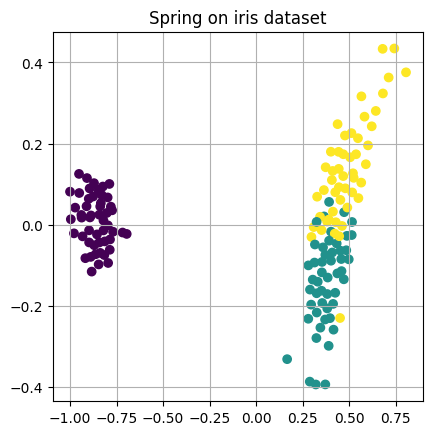

In [ ]:
visualization.show_data(embeddings, labels=labels, title='Spring on iris dataset', square=True, dpi=500, outpath='iris_spring.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9663193122700164
Continuity: 0.9700466311381805


#### Kamada Kawai

In [ ]:
embedder = embedding.KamadaKawaiEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder, compute_graph=False)

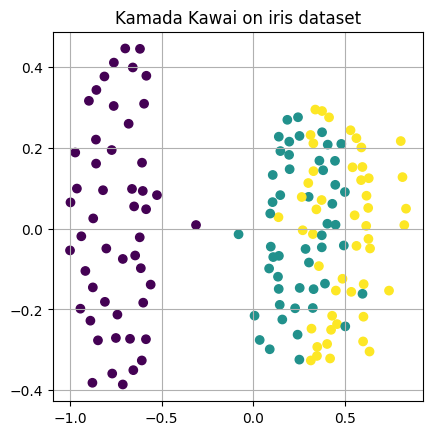

In [ ]:
visualization.show_data(embeddings, labels=labels, title='Kamada Kawai on iris dataset', square=True, dpi=500, outpath='iris_kamada.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9147871463012308
Continuity: 0.9258739373175993


#### GraphSAGE

In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)
    embedder = embedding.GraphSAGEEmbedder()
    embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    visualization.show_data(embeddings, labels=labels, title='GraphSAGE on iris dataset', square=True, dpi=500, outpath='iris_graphsage.png')

Unsupported python version, use python 3.6


In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9147871463012308
Continuity: 0.9258739373175993


#### Comparison: PCA

In [ ]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

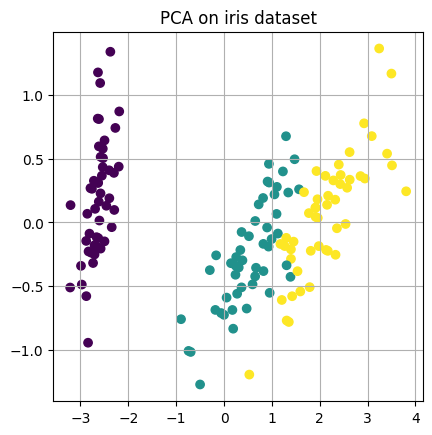

In [ ]:
visualization.show_data(embeddings, labels=labels, title='PCA on iris dataset', square=True, dpi=500, outpath='iris_pca.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9838139195533562
Continuity: 0.9937428625808907


#### Comparison: UMAP

In [ ]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

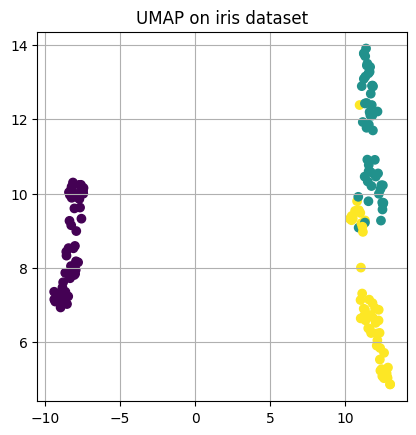

In [ ]:
visualization.show_data(embeddings, labels=labels, title='UMAP on iris dataset', square=True, dpi=500, outpath='iris_umap.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9866133739373176
Continuity: 0.9905944677071438


### Dataset: Digits

In [ ]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Spring

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [ ]:
embedder = embedding.SpringEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

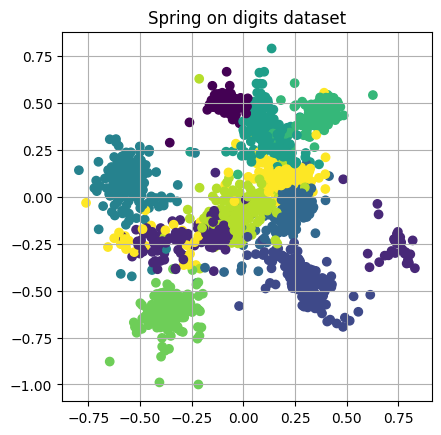

In [ ]:
visualization.show_data(embeddings, labels=labels, title='Spring on digits dataset', square=True, dpi=500, outpath='digits_spring.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9414986956323383
Continuity: 0.9821980254071743


#### Kamada Kawai

In [ ]:
embedder = embedding.KamadaKawaiEmbedder()
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

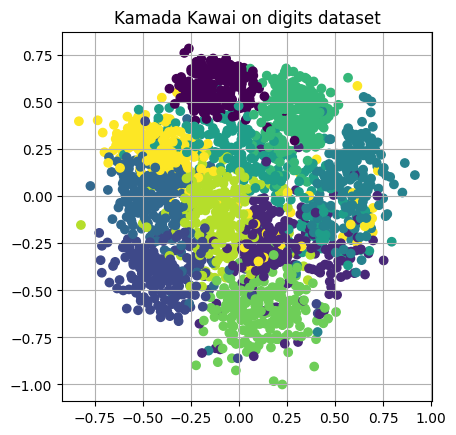

In [ ]:
visualization.show_data(embeddings, labels=labels, title='Kamada Kawai on digits dataset', square=True, dpi=500, outpath='digits_kamada.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8717686313056534
Continuity: 0.9663043883988005


#### GraphSAGE

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)

In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    embedder = embedding.GraphSAGEEmbedder()
    embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    visualization.show_data(embeddings, labels=labels, title='GraphSAGE on digits dataset', square=True, dpi=500, outpath='digits_graphsage.png')

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    evaluation.print_evaluation(data, embeddings)

Unsupported python version, use python 3.6


#### Comparison: PCA

In [ ]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

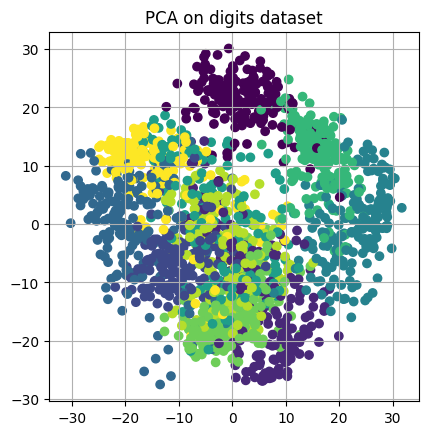

In [ ]:
visualization.show_data(embeddings, labels=labels, title='PCA on digits dataset', square=True, dpi=500, outpath='digits_pca.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8591163686736094
Continuity: 0.9645351453467876


#### Comparison: UMAP

In [ ]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

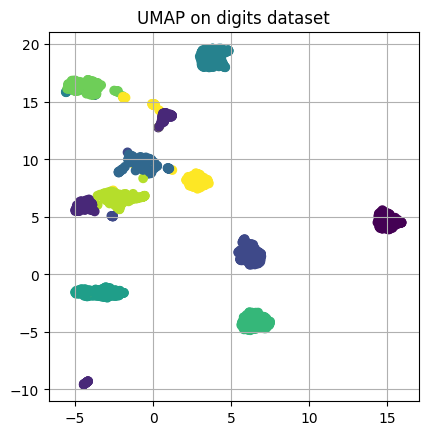

In [ ]:
visualization.show_data(embeddings, labels=labels, title='UMAP on digits dataset', square=True, dpi=500, outpath='digits_umap.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9921283796394221
Continuity: 0.9922218524094512


### Dataset: Swiss roll

In [ ]:
from sklearn.datasets import make_swiss_roll

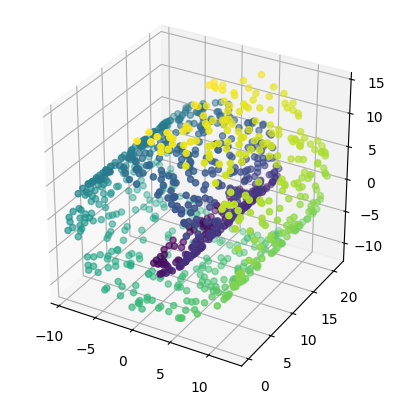

In [ ]:
data, labels = make_swiss_roll(n_samples=1000, noise=0.0, random_state=0)
visualization.show_data(data, labels=labels, square=True, dpi=500, outpath='swissroll.png')

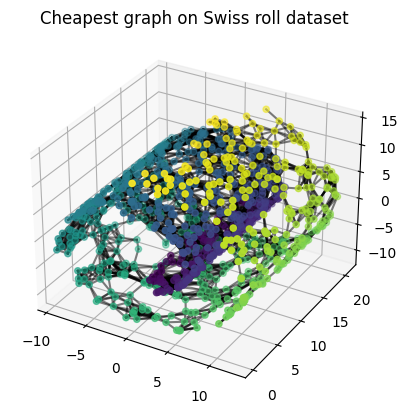

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal, feature_fun=features.feature_coords)
builder.build(data)
visualization.show_data(data, graph=builder.graph, labels=labels, title='Cheapest graph on Swiss roll dataset', dpi=500, outpath='swissroll_graph.png')

#### Spring

In [ ]:
embedder = embedding.SpringEmbedder()
embedder.embed(builder.graph)
embeddings = embedder.embeddings

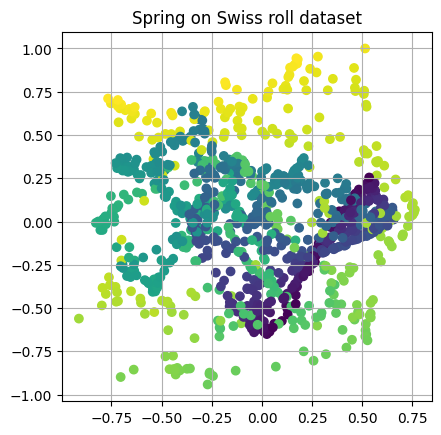

In [ ]:
visualization.show_data(embeddings, labels=labels, square=True, title='Spring on Swiss roll dataset', dpi=500, outpath='swissroll_spring.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.8805880402053614
Continuity: 0.993086406312321


#### Kamada Kawai

In [ ]:
embedder = embedding.KamadaKawaiEmbedder()
embedder.embed(builder.graph)
embeddings = embedder.embeddings

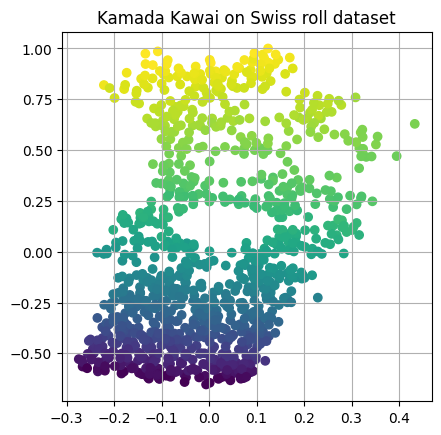

In [ ]:
visualization.show_data(embeddings, labels=labels, square=True, title='Kamada Kawai on Swiss roll dataset', dpi=500, outpath='swissroll_kamada.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9983891242702925
Continuity: 0.9981287094412304


#### GraphSAGE

In [ ]:
if sys.version_info[:3] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    embedder = embedding.GraphSAGEEmbedder(epochs=4, num_samples=[10, 5], layer_sizes=[20, 2])
    embedder.embed(builder.graph)
    embeddings = embedder.embeddings

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    visualization.show_data(embeddings, labels=labels, square=True, title='GraphSAGE on Swiss roll dataset', dpi=500, outpath='swissroll_graphsage.png')

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    evaluation.print_evaluation(data, embeddings)

Unsupported python version, use python 3.6


#### Comparison: PCA

In [ ]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(data)

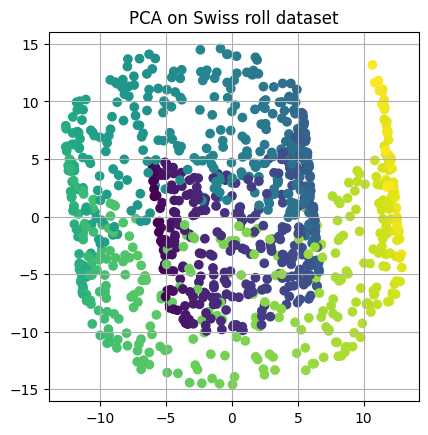

In [ ]:
visualization.show_data(embeddings, labels=labels, square=True, title='PCA on Swiss roll dataset', dpi=500, outpath='swissroll_pca.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9258147035924814
Continuity: 0.9974344939098212


#### Comparison: UMAP

In [ ]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
embeddings = umap_obj.fit_transform(data)

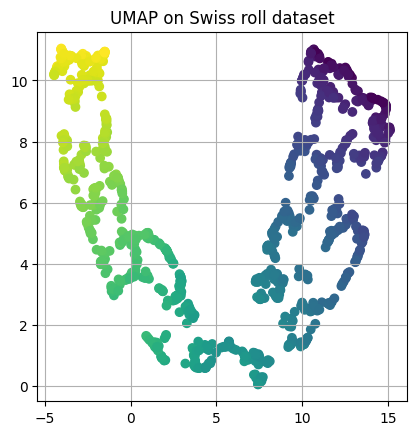

In [ ]:
visualization.show_data(embeddings, labels=labels, square=True, title='UMAP on Swiss roll dataset', dpi=500, outpath='swissroll_umap.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9993768525154897
Continuity: 0.9985710786315016


### Reduction to dimension 10
We show dimensionality reduction from dimension 64 to dimension 10. We use the Digits dataset.
We can not use Spring embedder, since it can only project to 2D. However, we can use Kamada Kawai and GraphSAGE.

In [ ]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### Kamada Kawai

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)

In [ ]:
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9948573905181388
Continuity: 0.993698545910009


#### GraphSAGE

In [ ]:
builder = build.CheapestBuilder(weight_fun=weights.get_reciprocal_pow(5), feature_fun=features.feature_coords)

In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    embedder = embedding.GraphSAGEEmbedder(embedding_dim=10)
    embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

Unsupported python version, use python 3.6


In [ ]:
if sys.version_info[:2] != (3,6):
    print('Unsupported python version, use python 3.6')
else:
    evaluation.print_evaluation(data, embeddings)

Unsupported python version, use python 3.6


#### Comparison: PCA

In [ ]:
pca = PCA(n_components=10)
embeddings = pca.fit_transform(data)

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9978980809827757
Continuity: 0.9989615864760506


#### Comparison: UMAP

In [ ]:
umap_obj = umap.UMAP(n_components=10, random_state=42)
embeddings = umap_obj.fit_transform(data)

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.996228013421093
Continuity: 0.9945406303268592


## Other experiments

### Spanning tree builder

We also tried using spanning tree as a graph instead of our CheapestBuilder graph. The best results were obtained using Kamada & Kawai embedder.

In [ ]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

#### 2D

In [ ]:
builder = build.SpanningTreeBuilder(weight_fun=weights.reciprocal)
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=2)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

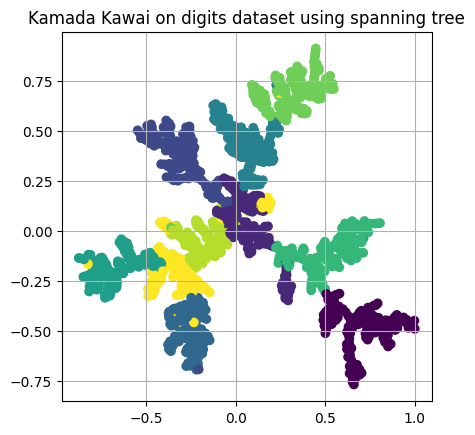

In [ ]:
visualization.show_data(embeddings, labels=labels, square=True, title='Kamada Kawai on digits dataset using spanning tree', dpi=500, outpath='digits_kamada_spanning.png')

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9865582735066131
Continuity: 0.9840249696200537


#### 10D

In [ ]:
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

In [ ]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.9949604542268563
Continuity: 0.98616888139586


### Data compression

We can ask, if our algorithm can actually compress data. As we saw, we have very good results for spanning tree graph and Kamada Kawai embedder when projecting to 10 dimensions. If our graph takes less space than the embedded data in 10d, our graph is compressed version of the full dataset and even the 10d dataset, while containing most of the essential information.

In [ ]:
digits = load_digits()
data = digits.data
labels = digits.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

In [ ]:
builder = build.SpanningTreeBuilder(weight_fun=weights.reciprocal)
embedder = embedding.KamadaKawaiEmbedder(embedding_dim=10)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

In [ ]:
utils.print_compression(builder, embedder)

Graph file size: 43232
Embeddings file size: 143888
improvement: 0.3004559101523407


We see that the graph can be stored in three time less space than the data in 10D. 

### Unsuccessful experiment: Node2vec

In [96]:
iris = load_iris()
data = iris.data
labels = iris.target
data, labels = preprocessing.remove_duplicities(data, labels, shuffle=True, normalize=False)

In [97]:
builder = build.CheapestBuilder(weight_fun=weights.reciprocal)
embedder = embedding.Node2VecEmbedder(embedding_dim=2)
embeddings = dim_reduction.reduce_dimension(data, builder, embedder)

Computing transition probabilities:   0%|          | 0/149 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


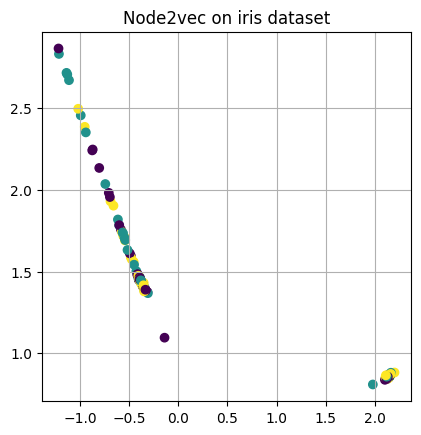

In [98]:
visualization.show_data(embeddings, labels=labels, square=True, title='Node2vec on iris dataset')

For some unknown reason, Node2vec projects on a line and a point in upper left corner. Also metrics are not good.  

In [99]:
evaluation.print_evaluation(data, embeddings)

Trustworthiness: 0.5978936683162035
Continuity: 0.5918585839360487
